In [1]:
import os
import numpy as np
import pandas as pd
import rasterio as rio
import geopandas as gpd
from rasterio.plot import show
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

-------------------------

# __Nebraska HPA__

## Is ET more correlated to precipitation or Irrigation?

### ET vs Precip : Irrigated

In [3]:
NE_monthly_df = pd.read_csv('../../Data_main/Data_Drivers_of_ET/CSVs/2km/NE_monthly.csv')
# NE_monthly_df.head()

In [4]:
NE_irrigated_df = NE_monthly_df[NE_monthly_df['Irrigated'] == 1]
# NE_irrigated_df.head()

In [5]:
x = NE_irrigated_df[['PRISM_PPT']]
y = NE_irrigated_df[['Irrigated_cropET']]

#train-test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0, shuffle=True)
x_train, x_test, y_train, y_test = x_train.values, x_test.values, y_train.values, y_test.values

# linear model
lm = LinearRegression()
lm_trained = lm.fit(x_train, y_train)
lm_trained.coef_

array([[0.11613877]])

Coefficient of determination: 0.02


Text(0, 0.5, 'Monthly Irrigated cropET (mm)')

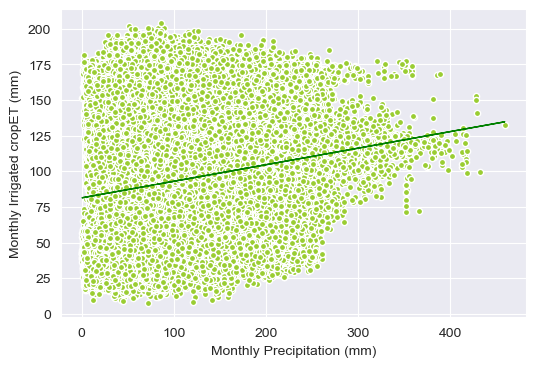

In [7]:
# R2 
y_test_pred = lm_trained.predict(x_test)
r2 = r2_score(y_test, y_test_pred)

# plot performance
fig, ax = plt.subplots(figsize=(6, 4))
sns.set_style("darkgrid")

print("Coefficient of determination: %.2f" % r2)
plt.scatter(x_test, y_test, facecolor='yellowgreen', edgecolor='white', s=20)
plt.plot(x_test, y_test_pred, color='green', linewidth=1)
plt.xlabel('Monthly Precipitation (mm)')
plt.ylabel('Monthly Irrigated cropET (mm)')

## ET vs Precip : Rainfed

In [10]:
NE_rainfed_df = NE_monthly_df[NE_monthly_df['Rainfed'] == 1]
# NE_rainfed_df.head()

In [11]:
x = NE_rainfed_df[['PRISM_PPT']]
y = NE_rainfed_df[['Rainfed_cropET']]

#train-test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0, shuffle=True)
x_train, x_test, y_train, y_test = x_train.values, x_test.values, y_train.values, y_test.values

# linear model
lm = LinearRegression()
lm_trained = lm.fit(x_train, y_train)
lm_trained.coef_

array([[0.1825101]])

Coefficient of determination: 0.08


Text(0, 0.5, 'Monthly Rainfed cropET (mm)')

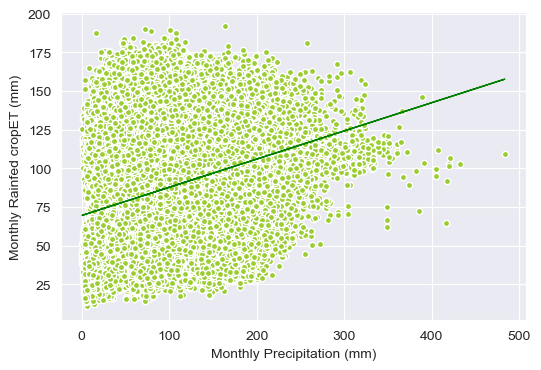

In [12]:
# R2 
y_test_pred = lm_trained.predict(x_test)
r2 = r2_score(y_test, y_test_pred)

# plot performance
fig, ax = plt.subplots(figsize=(6, 4))
sns.set_style("darkgrid")

print("Coefficient of determination: %.2f" % r2)
plt.scatter(x_test, y_test, facecolor='yellowgreen', edgecolor='white', s=20)
plt.plot(x_test, y_test_pred, color='green', linewidth=1)
plt.xlabel('Monthly Precipitation (mm)')
plt.ylabel('Monthly Rainfed cropET (mm)')

# How ET varies with crop type

In [3]:
# USDA CDL crop classification
USDA_cdl_class_df = pd.read_csv('../../Data_main\Data_Drivers_of_ET/CSVs/USDA_cdl_classification.csv')
USDA_cdl_class_df = USDA_cdl_class_df.set_index(keys='Class')
# USDA_cdl_class_df.head()

# making the df to a dictionary
usda_cdl_dict = USDA_cdl_class_df.to_dict()
usda_cdl_dict = usda_cdl_dict['Crop']
# usda_cdl_dict

## Irrigated vs rainfed monthly

In [4]:
NE_monthly_df = pd.read_csv('../../Data_main/Data_Drivers_of_ET/CSVs/2km/NE_monthly.csv')

# irrigated and rainfed crop status and irrigated and rainfed cropET are exclusive. Creating columns to bring them in same colums for plotting purpose
NE_monthly_df['Irrig_stat'] = ['Irrigated'  if i == 1 else 'Rainfed' for i in NE_monthly_df.Irrigated] 
NE_monthly_df['Irrig_rainfed_cropET'] = NE_monthly_df['Irrigated_cropET'] + NE_monthly_df['Rainfed_cropET']

# filtering out some cells which are neither irrigated or rainfed (0 values were assigned from reference raster)
NE_monthly_df = NE_monthly_df[(NE_monthly_df.Irrigated == 1) | (NE_monthly_df.Rainfed == 1)]

# mapping name of crop type using USDA CDL dictionary
NE_monthly_df.loc[:, 'Crop'] = NE_monthly_df['USDA_CDL'].map(usda_cdl_dict)
NE_monthly_df.head()

,OpenET,year,month,Irrigated_cropET,Rainfed_cropET,PRISM_PPT,USDA_CDL,Irrigated,Rainfed,Irrig_stat,Irrig_rainfed_cropET,Crop
0,29.0,2016,4,14.562966,0.000000,126.700,1.0,1.0,0.0,Irrigated,14.562966,Corn
1,62.0,2016,4,0.000000,54.465360,133.785,176.0,0.0,1.0,Rainfed,54.465360,Grassland/Pasture
2,26.0,2016,4,0.000000,21.415382,129.949,1.0,0.0,1.0,Rainfed,21.415382,Corn
3,17.0,2016,4,12.732964,0.000000,131.828,1.0,1.0,0.0,Irrigated,12.732964,Corn
4,37.0,2016,4,37.542870,0.000000,131.828,5.0,1.0,0.0,Irrigated,37.542870,Soybeans


In [5]:
# Filtering Irrigated data only for NE
NE_irrigated_df = NE_monthly_df[NE_monthly_df['Irrigated'] == 1]
print(f'{len(NE_irrigated_df.Crop.unique())} Unique irrigated crop types in NE', NE_irrigated_df.Crop.unique())
NE_irrigated_df_filtered = NE_irrigated_df[NE_irrigated_df['Crop'].isin(['Corn', 'Winter Wheat', 'Alfalfa', 'Soybeans', 'Grassland/Pasture'])]
NE_irrigated_df_filtered = NE_irrigated_df_filtered[NE_irrigated_df['month'].isin([7, 8, 9, 10])]

# Filtering Rainfed data only for NE
NE_rainfed_df = NE_monthly_df[NE_monthly_df['Rainfed'] == 1]
print(f'{len(NE_rainfed_df.Crop.unique())}Unique rainfed crop types in NE', NE_rainfed_df.Crop.unique())
NE_rainfed_df_filtered = NE_rainfed_df[NE_rainfed_df['Crop'].isin(['Corn', 'Winter Wheat', 'Alfalfa', 'Soybeans', 'Grassland/Pasture'])]
NE_rainfed_df_filtered = NE_rainfed_df_filtered[NE_rainfed_df_filtered['month'].isin([7, 8, 9, 10])]

16 Unique irrigated crop types in NE ['Corn' 'Soybeans' 'Alfalfa' 'Grassland/Pasture' 'Oats' 'Winter Wheat'
 'Other Hay/Non Alfalfa' 'Pop or Orn Corn' 'Sorghum' 'Triticale' 'Rye'
 'Millet' 'Peas' 'Dbl Crop Barley/Corn' 'Dry Beans'
 'Dbl Crop Barley/Soybeans']


C:\Users\fahim\AppData\Local\Temp\ipykernel_2276\331274675.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  NE_irrigated_df_filtered = NE_irrigated_df_filtered[NE_irrigated_df['month'].isin([7, 8, 9, 10])]


11Unique rainfed crop types in NE ['Grassland/Pasture' 'Corn' 'Soybeans' 'Alfalfa' 'Other Hay/Non Alfalfa'
 'Winter Wheat' 'Sorghum' 'Millet' 'Peas' 'Oats' 'Spring Wheat']


(0.0, 300.0)

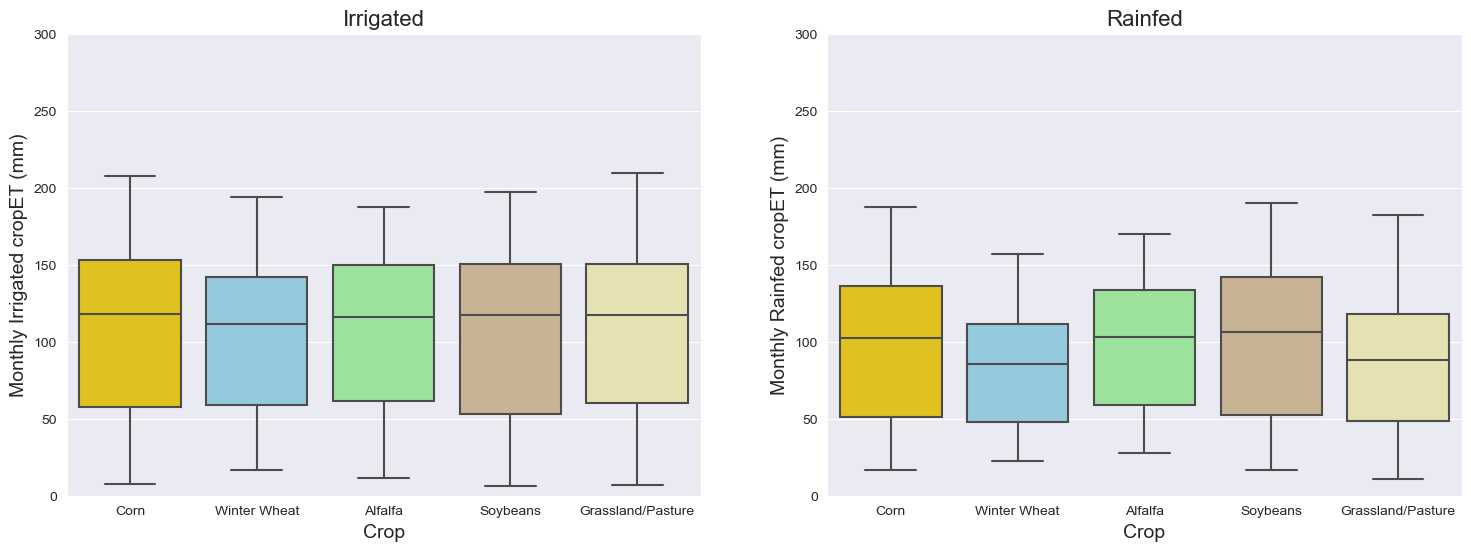

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(18, 6))
sns.set_style("darkgrid")

# setting similar color palette for similar crops 
category_colors = {'Corn': 'gold', 'Winter Wheat': 'skyblue', 'Sorghum': 'indianred', 'Alfalfa': 'lightgreen', 
                    'Soybeans': 'tan', 'Grassland/Pasture': 'palegoldenrod'}

# category order
category_order_irr = ['Corn', 'Winter Wheat', 'Alfalfa', 'Soybeans', 'Grassland/Pasture']
category_order_rain = ['Corn', 'Winter Wheat', 'Alfalfa', 'Soybeans', 'Grassland/Pasture']

# irrigated
sns.boxplot(x=NE_irrigated_df_filtered['Crop'], y=NE_irrigated_df_filtered['Irrigated_cropET'], ax=ax[0], palette=category_colors, order=category_order_irr)
ax[0].set_xlabel('Crop', fontsize=14)
ax[0].set_ylabel('Monthly Irrigated cropET (mm)', fontsize=14)
ax[0].tick_params(axis='both', labelsize=10)
ax[0].set_title('Irrigated', fontsize=16)
ax[0].set_ylim(0, 300)

# rainfed
sns.boxplot(x=NE_rainfed_df_filtered['Crop'], y=NE_rainfed_df_filtered['Rainfed_cropET'], ax=ax[1], palette=category_colors, order=category_order_rain)
ax[1].set_xlabel('Crop', fontsize=14)
ax[1].set_ylabel('Monthly Rainfed cropET (mm)', fontsize=14)
ax[1].tick_params(axis='both', labelsize=10)
ax[1].set_title('Rainfed', fontsize=16)
ax[1].set_ylim(0, 300)

Except Soybeans, all other crops seems to have higher median irrigated cropET than rainfed cropET

#### Corn

(0.0, 300.0)

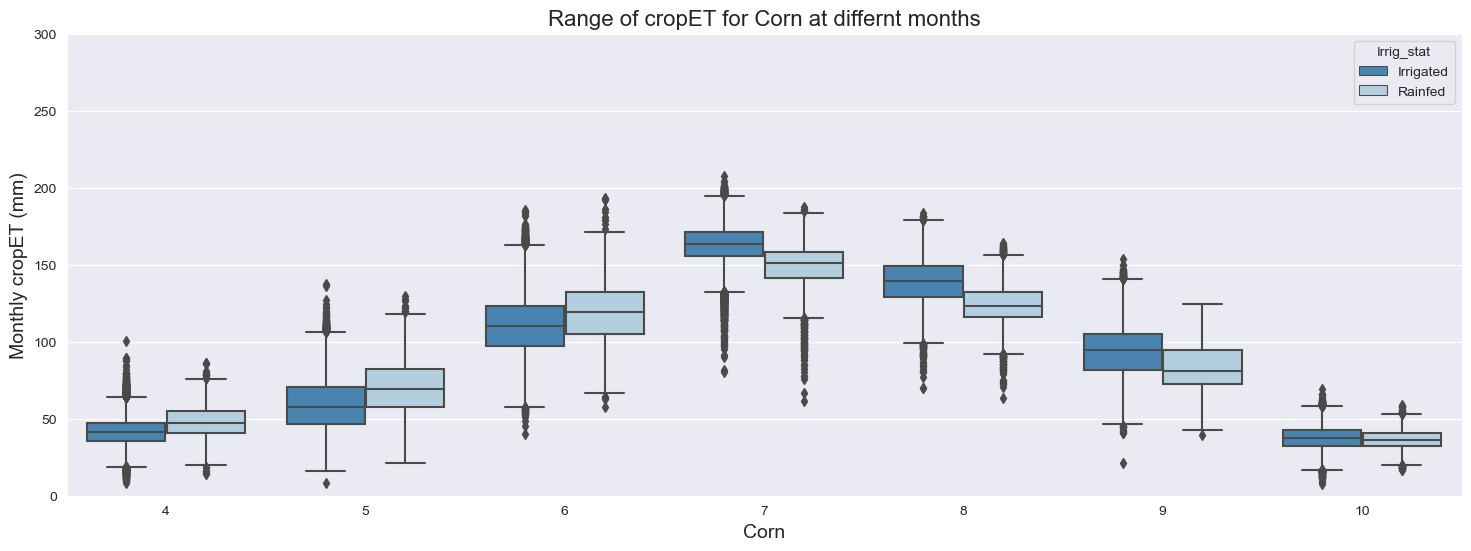

In [8]:
NE_df_crop = NE_monthly_df[NE_monthly_df['Crop'] == 'Corn']

fig, ax = plt.subplots(figsize=(18, 6))
sns.set_style("darkgrid")

sns.boxplot(x=NE_df_crop['month'], y=NE_df_crop['Irrig_rainfed_cropET'], ax=ax, hue=NE_df_crop['Irrig_stat'], palette='Blues_r')
ax.set_xlabel('Corn', fontsize=14)
ax.set_ylabel('Monthly cropET (mm)', fontsize=14)
ax.tick_params(axis='both', labelsize=10)
ax.set_title('Range of cropET for Corn at differnt months', fontsize=16)
ax.set_ylim(0, 300)

#### WInter Wheat

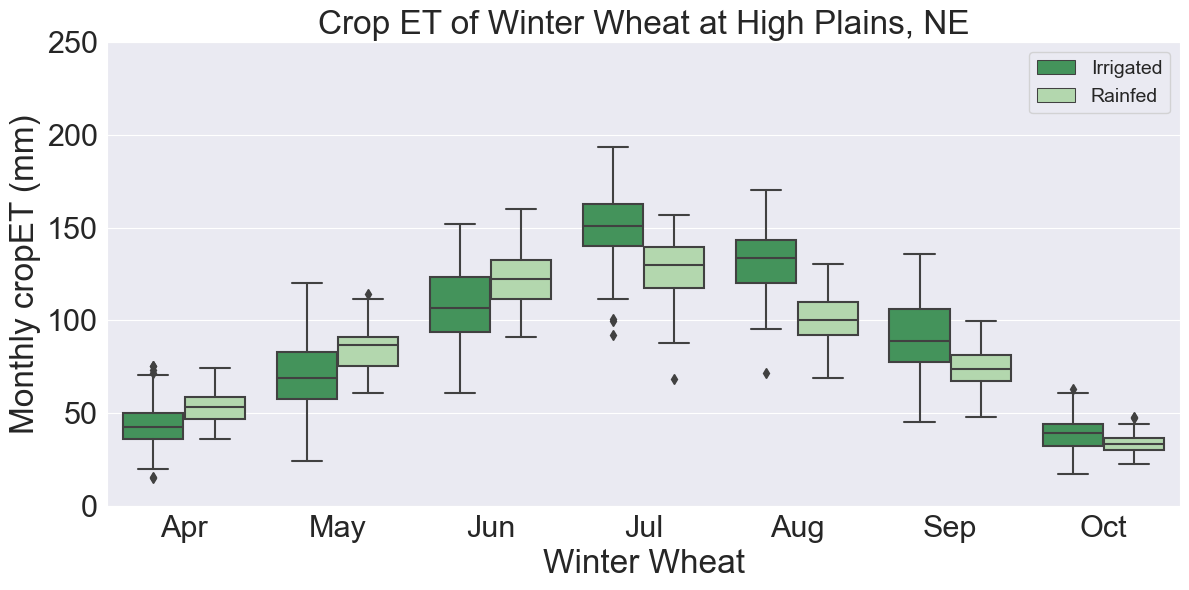

In [8]:
NE_df_crop = NE_monthly_df[NE_monthly_df['Crop'] == 'Winter Wheat']
months = ['Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct']

fig, ax = plt.subplots(figsize=(12, 6))
sns.set_style("darkgrid")
fig.set_facecolor('none')

sns.boxplot(x=NE_df_crop['month'], y=NE_df_crop['Irrig_rainfed_cropET'], ax=ax, 
            hue=NE_df_crop['Irrig_stat'], hue_order=['Irrigated', 'Rainfed'],
            palette='Greens_r')
ax.set_xlabel('Winter Wheat', fontsize=24)
ax.set_ylabel('Monthly cropET (mm)', fontsize=24)
ax.set_xticklabels(months)
ax.tick_params(axis='both', labelsize=22)
ax.set_title('Crop ET of Winter Wheat at High Plains, NE', fontsize=24)
ax.legend(prop = { "size": 14 })
ax.set_ylim(0, 250)
plt.tight_layout()

current_dir = os.getcwd()
figdir = 'figs'
figname = 'winter_wheat_NE_monthly_cropET.png'
fig.savefig(os.path.join(current_dir, figdir, figname), dpi=150)

#### Soybeans

(0.0, 200.0)

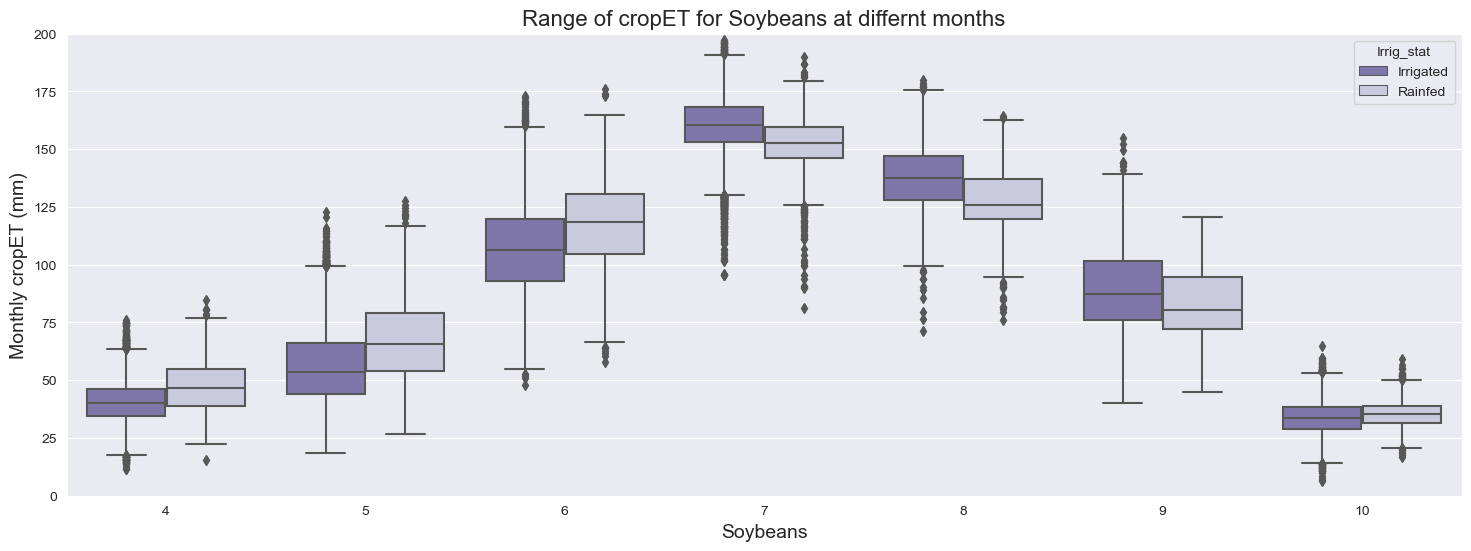

In [10]:
NE_df_crop = NE_monthly_df[NE_monthly_df['Crop'] == 'Soybeans']

fig, ax = plt.subplots(figsize=(18, 6))
sns.set_style("darkgrid")

sns.boxplot(x=NE_df_crop['month'], y=NE_df_crop['Irrig_rainfed_cropET'], ax=ax, hue=NE_df_crop['Irrig_stat'], palette='Purples_r')
ax.set_xlabel('Soybeans', fontsize=14)
ax.set_ylabel('Monthly cropET (mm)', fontsize=14)
ax.tick_params(axis='both', labelsize=10)
ax.set_title('Range of cropET for Soybeans at differnt months', fontsize=16)
ax.set_ylim(0, 200)

For Soybeans, median `irrigated cropET < rainfed cropET` for `4-6` but median __irrigated cropET > rainfed cropET__ for `7-10`.

### Ratio between Rainfed cropET (Effective Precip) vs Irrigated cropET __Using monthly medians__

In [11]:
NE_irrigated_df = NE_monthly_df[NE_monthly_df['Irrigated'] == 1]
irrigated_cropET_df = NE_irrigated_df.groupby(by='Crop', axis=0)['Irrigated_cropET'].median()
irrigated_cropET_df = irrigated_cropET_df.reset_index()

NE_rainfed_df = NE_monthly_df[NE_monthly_df['Rainfed'] == 1]
rainfed_cropET_df = NE_rainfed_df.groupby(by='Crop', axis=0)['Rainfed_cropET'].median()
rainfed_cropET_df = rainfed_cropET_df.reset_index()

# merging 2 dataframes
effective_precip_ratio_df = irrigated_cropET_df.merge(rainfed_cropET_df, on=['Crop'], how='inner')
effective_precip_ratio_df['ratio_effec_precip'] = effective_precip_ratio_df['Rainfed_cropET'] / effective_precip_ratio_df['Irrigated_cropET']
effective_precip_ratio_df

,Crop,Irrigated_cropET,Rainfed_cropET,ratio_effec_precip
0,Alfalfa,97.582490,89.555170,0.917738
1,Corn,89.550260,86.404790,0.964875
2,Grassland/Pasture,92.580345,83.607765,0.903083
3,Millet,77.643612,71.936505,0.926496
4,Oats,88.499840,76.144100,0.860387
5,Other Hay/Non Alfalfa,96.632710,107.210915,1.109468
6,Peas,92.128388,93.048650,1.009989
7,Sorghum,87.158040,83.831050,0.961828
8,Soybeans,83.901344,85.381120,1.017637
9,Winter Wheat,88.594865,86.032119,0.971073


## Irrigated vs rainfed yearly

In [12]:
NE_yearly_df = pd.read_csv('../../Data_main/Data_Drivers_of_ET/CSVs/2km/NE_yearly.csv')

# irrigated and rainfed crop status and irrigated and rainfed cropET are exclusive. Creating columns to bring them in same colums for plotting purpose
NE_yearly_df['Irrig_stat'] = ['Irrigated'  if i == 1 else 'Rainfed' for i in NE_yearly_df.Irrigated] 
NE_yearly_df['Irrig_rainfed_cropET'] = NE_yearly_df['Irrigated_cropET'] + NE_yearly_df['Rainfed_cropET']

# filtering out some cells which are neither irrigated or rainfed (0 values were assigned from reference raster)
NE_yearly_df = NE_yearly_df[(NE_yearly_df.Irrigated == 1) | (NE_yearly_df.Rainfed == 1)]

# mapping name of crop type using USDA CDL dictionary
NE_yearly_df.loc[:, 'Crop'] = NE_yearly_df['USDA_CDL'].map(usda_cdl_dict)
NE_yearly_df.head()

,USDA_CDL,Irrigated,Rainfed,Irrigated_cropET,Rainfed_cropET,Irrig_stat,Irrig_rainfed_cropET,Crop
0,1.0,1.0,0.0,665.2049,0.00000,Irrigated,665.20490,Corn
1,176.0,0.0,1.0,0.0000,605.86536,Rainfed,605.86536,Grassland/Pasture
2,1.0,0.0,1.0,0.0000,610.49884,Rainfed,610.49884,Corn
3,1.0,1.0,0.0,637.4559,0.00000,Irrigated,637.45590,Corn
4,5.0,1.0,0.0,652.4927,0.00000,Irrigated,652.49270,Soybeans


(300.0, 1000.0)

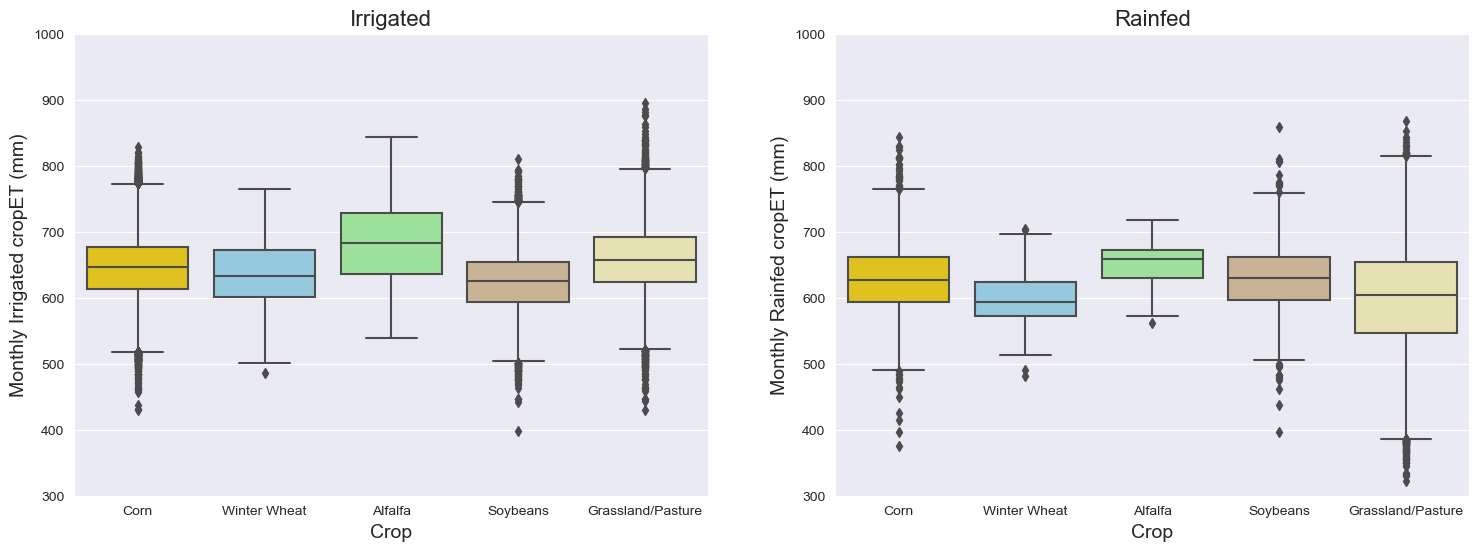

In [13]:
# Filtering Irrigated data only for NE
NE_irrigated_df = NE_yearly_df[NE_yearly_df['Irrigated'] == 1]
NE_irrigated_df_filtered = NE_irrigated_df[NE_irrigated_df['Crop'].isin(['Corn', 'Winter Wheat', 'Alfalfa', 'Soybeans', 'Grassland/Pasture'])]

# Filtering Rainfed data only for KS
NE_rainfed_df = NE_yearly_df[NE_yearly_df['Rainfed'] == 1]
NE_rainfed_df_filtered = NE_rainfed_df[NE_rainfed_df['Crop'].isin(['Corn', 'Winter Wheat', 'Alfalfa', 'Soybeans', 'Grassland/Pasture'])]

# Plotting major irrigated and rainfed crops' yearly irrigated and rainfed cropET
fig, ax = plt.subplots(1, 2, figsize=(18, 6))
sns.set_style("darkgrid")

# setting similar color palette for similar crops 
category_colors = {'Corn': 'gold', 'Winter Wheat': 'skyblue', 'Sorghum': 'indianred', 'Alfalfa': 'lightgreen', 
                          'Soybeans': 'tan', 'Grassland/Pasture': 'palegoldenrod'}

# category order
category_order_irr = ['Corn', 'Winter Wheat', 'Alfalfa', 'Soybeans', 'Grassland/Pasture']
category_order_rain = ['Corn', 'Winter Wheat', 'Alfalfa', 'Soybeans', 'Grassland/Pasture']

# irrigated
sns.boxplot(x=NE_irrigated_df_filtered['Crop'], y=NE_irrigated_df_filtered['Irrigated_cropET'], ax=ax[0], palette=category_colors, order=category_order_irr)
ax[0].set_xlabel('Crop', fontsize=14)
ax[0].set_ylabel('Monthly Irrigated cropET (mm)', fontsize=14)
ax[0].tick_params(axis='both', labelsize=10)
ax[0].set_title('Irrigated', fontsize=16)
ax[0].set_ylim(300, 1000)

# rainfed
sns.boxplot(x=NE_rainfed_df_filtered['Crop'], y=NE_rainfed_df_filtered['Rainfed_cropET'], ax=ax[1], palette=category_colors, order=category_order_rain)
ax[1].set_xlabel('Crop', fontsize=14)
ax[1].set_ylabel('Monthly Rainfed cropET (mm)', fontsize=14)
ax[1].tick_params(axis='both', labelsize=10)
ax[1].set_title('Rainfed', fontsize=16)
ax[1].set_ylim(300, 1000)

### Ratio between Rainfed cropET (Effective Precip) vs Irrigated cropET __Using yearly medians__

In [14]:
NE_irrigated_df = NE_yearly_df[NE_yearly_df['Irrigated'] == 1]
irrigated_cropET_df_count = NE_irrigated_df.groupby(by='Crop', axis=0)['Irrigated_cropET'].count().reset_index()
irrigated_cropET_df_count = irrigated_cropET_df_count.rename(columns={'Irrigated_cropET': 'Irr_count'})
irrigated_cropET_df = NE_irrigated_df.groupby(by='Crop', axis=0)['Irrigated_cropET'].median()
irrigated_cropET_df = irrigated_cropET_df.reset_index()


NE_rainfed_df = NE_yearly_df[NE_yearly_df['Rainfed'] == 1]
rainfed_cropET_df_count = NE_rainfed_df.groupby(by='Crop', axis=0)['Rainfed_cropET'].count().reset_index()
rainfed_cropET_df_count = rainfed_cropET_df_count.rename(columns={'Rainfed_cropET': 'Rain_count'})
rainfed_cropET_df = NE_rainfed_df.groupby(by='Crop', axis=0)['Rainfed_cropET'].median()
rainfed_cropET_df = rainfed_cropET_df.reset_index()

# merging 2 dataframes
effective_precip_ratio_df = irrigated_cropET_df.merge(rainfed_cropET_df, on=['Crop']).merge(irrigated_cropET_df_count, on='Crop').merge(rainfed_cropET_df_count, on='Crop')
effective_precip_ratio_df['ratio_effec_precip'] = effective_precip_ratio_df['Rainfed_cropET'] / effective_precip_ratio_df['Irrigated_cropET']
effective_precip_ratio_df

,Crop,Irrigated_cropET,Rainfed_cropET,Irr_count,Rain_count,ratio_effec_precip
0,Alfalfa,682.220200,658.17470,417,43,0.964754
1,Corn,645.944030,626.15520,45401,2445,0.969364
2,Grassland/Pasture,657.476220,604.06915,16402,28945,0.918770
3,Millet,638.166315,500.02310,2,2,0.783531
4,Oats,616.236300,586.37220,9,3,0.951538
5,Other Hay/Non Alfalfa,651.257850,749.15320,24,37,1.150317
6,Peas,642.483450,594.15110,2,1,0.924773
7,Sorghum,657.892065,597.14621,24,18,0.907666
8,Soybeans,624.950260,630.62890,17511,1277,1.009087
9,Winter Wheat,632.239530,594.05322,136,74,0.939602


We can only trust crops that have relatively significat samples on both side (not disproportionate)
- Alfalfa, Corn, Grassland/pasture, Sorghum, Winter Wheat

In [26]:
selected_crops = ['Alfalfa','Corn', 'Sorghum', 'Winter Wheat']
effective_precip_ratio_df = effective_precip_ratio_df[effective_precip_ratio_df['Crop'].isin(selected_crops)]
effective_precip_ratio_df = effective_precip_ratio_df.reset_index(drop=True)
effective_precip_ratio_df

,Crop,Irrigated_cropET,Rainfed_cropET,Irr_count,Rain_count,ratio_effec_precip
0,Alfalfa,682.220200,658.17470,417,43,0.964754
1,Corn,645.944030,626.15520,45401,2445,0.969364
2,Sorghum,657.892065,597.14621,24,18,0.907666
3,Winter Wheat,632.239530,594.05322,136,74,0.939602


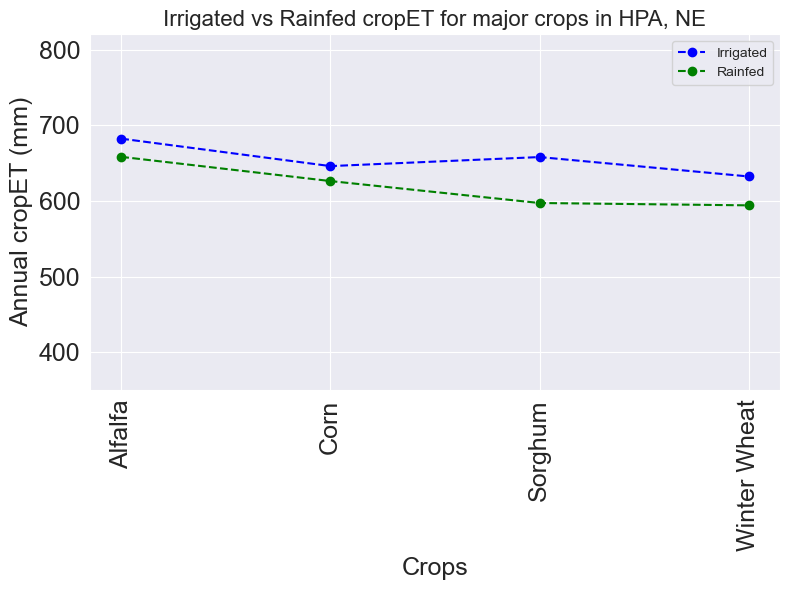

In [31]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.set_style("darkgrid")
fig.set_facecolor('none')

ax.plot(effective_precip_ratio_df.Irrigated_cropET, 'b--', label='Irrigated', marker='o')
ax.plot(effective_precip_ratio_df.Rainfed_cropET, 'g--', label='Rainfed', marker='o')
ax.set_xticks(list(range(len(effective_precip_ratio_df))), labels= effective_precip_ratio_df.Crop, rotation=90, fontsize=12)
ax.set_xlabel('Crops', fontsize=18)
ax.set_ylabel('Annual cropET (mm)', fontsize=18)
ax.set_ylim(350, 820)
ax.tick_params(axis='both', labelsize=18)
ax.set_title('Irrigated vs Rainfed cropET for major crops in HPA, NE', fontsize=16)
ax.legend()
plt.tight_layout()

current_dir = os.getcwd()
figdir = 'figs'
figname = 'Annual_Irrig_vs_Rain_cropET_NE.png'
fig.savefig(os.path.join(current_dir, figdir, figname), dpi=150)